# Real life PDF fit

In the previous tutorial (PDF Fitting) we have fitted a Neural Network to PDF data that we have obtained from LHAPDF. Ah! If life were so simple!

Reality is much more complicated:

1. We cannot measure the PDF: we have no PDF data!

2. The data has some uncertainties associated to it.

In this tutorial we are going to do a more realistic (albeit simplified) PDF fit.

## From the PDF to the experimental data

In an experiment we only have access to observables. These observables, while they can be computed theoretically, depend on the PDF in a non trivial manner, for hadronic collision (such as those at the LHC) we have:

\begin{equation}
    \mathcal{O} = \displaystyle\sum_{ij} \int dx_{1} dx_{2}  \  f_{i}  (x_1, \mu_F) \  f_{j}(x_2, \mu_F) \ \hat{\sigma}_{ij}(x_{1}, x_{2}, \mu_{R}, \mu_{F})
\end{equation}

For simplicity (and because that topic was already covered in the tutorials of the third day) we are going to drop the dependence on $\mu_F$ from the PDF. All scale-dependence is contained in the partonic cross section instead

Utilizing the model of the PDF that we built in the previous tutorial our PDF have instead the following form: $f_{i}(x) = (1 - x)^{1+\beta}NN_{i}(x)$ where the index $i$ refers to the parton.

\begin{equation}
    \mathcal{O} = \displaystyle\sum_{ij} \int dx_{1} dx_{2}  \ (1 - x_1)^{1+\beta}NN_{i}(x_1) \ (1 - x_2)^{1+\beta}NN_{j}(x_2) \ \hat{\sigma}_{ij}(x_{1}, x_{2}, \mu_{R}, \mu_{F})
\end{equation}

Note that in the previous equation both Neural Networks are the same, but are evaluated at different values of $x$ (and potentially contribute with different partons $i$ and $j$). This means the observable depends non-linearly on the Neural Network, which greatly complicates the training. For this tutorial we are going to limit ourselves to DIS observables so one of the two PDFs is set to 1, which will facilitate the construction of the network, but in a global PDF fit both DIS and double-hadronic observables need to be considered.

Up to this point we have used Mean Squared Errors as the loss function to be optimized. In this case we are comparing datapoints ($D$) with observables ($\mathcal{O}$). The loss function thus looks like:

\begin{equation}
    L = \frac{1}{N}\sum_{k} (\mathcal{O}_{k} - D_{k})^2 = \frac{1}{N}\sum_{k}\left(\displaystyle\sum_{ij} \int dx_{1} dx_{2}  \ (1 - x_1)^{1+\beta}NN_{i}(x_1) \ (1 - x_2)^{1+\beta}NN_{j}(x_2) \ \hat{\sigma}_{ij}^{(k)}(x_{1}, x_{2}, \mu_{R}, \mu_{F}) - D_{k}\right)^2
\end{equation}

with $k$ running over datapoints in the fit. This loss function corresponds and it is usually called $\chi^{2}$.


## Experimental uncertainties

In addition to the previous consideration, we need to include the information about the experimental uncertainties. Experimental uncertainties introduce correlations between datapoints which need to be taken into account:

\begin{equation}
    L = \frac{1}{N}\sum_{k,l} (\mathcal{O}_{k} - D_{k})s_{kl}^{-1}(\mathcal{O}_{l} - D_{l})
\end{equation}

With $s_{kl}^{-1}$ the inverse of the covariance matrix. In the limit of a diagional covariance matrix (no correlation between datapoints) one would recover the simpler form that we have used before.

## Tutorial outline

In this tutorial we are going to take the final multi-flavour PDF we constructed in the previous one as the starting point.

In order to have a realistic-looking PDF from only a few datasets, we are going to use the `.npz` files that you downloaded in the first day of the school. They contain:

- `D`: the experimental data
- `covmat`: the experimetal covariance matrix
- `fktable`: an interpolation table for the partonic cross section the fktable is a tensor `(ndata, luminosity channel, x)`
- `xgrid`: grid in x in which to evaluate the PDF
- `luminosity`: the relevant indices of the luminosity

The first thing we will do is to create an observable that we can compare to data. In a first step we will simply compare to data without taking into account the experimental uncertainties. 

Then we will create a custom loss function, introducing the covariance matrix into the problem.

We will finish the tutorials creating replicas of the data to generate a PDF ensemble.

In [1]:
from pathlib import Path

import numpy as np
import tensorflow as tf
from lhapdf import setVerbosity
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential

tf.keras.backend.clear_session()
setVerbosity(0)

data_folder = Path("data") / "pdf_fit"
if not data_folder.exists():
    print("Warning! The data folder does not exist!")

available_datasets = ["HERACOMBNCEP920", "HERACOMBCCEM", "SLACP", "HERACOMB_SIGMARED_B"]

## The PDF model

To create the PDF model we are going to copy some of the functions that we prepared in the tutorial PDF Fitting

In [2]:
class Preprocessing(tf.keras.layers.Layer):
    """This layer generates a preprocessing (1-x)**(1+beta)"""

    def build(self, input_shape):
        """The build function will be called before a forward pass and the trainable weight
        will be generated. Beta is constrained to be a positive value to avoid 1/0"""
        self._beta = self.add_weight(
            shape=(1,),
            trainable=True,
            name="beta",
            constraint=tf.keras.constraints.non_neg(),
            initializer="ones",
        )

    def call(self, x):
        return (1.0 - x) ** (self._beta + 1.0)


class InputScaling(tf.keras.layers.Layer):
    """This layer applies a logarithmic scaling to the input and then concatenates it to the actual input
    This layer is dim=1 --> dim=2
    """

    def call(self, x):
        return tf.concat([x, tf.math.log(x)], axis=-1)


def generate_pdf_model(outputs=9, units=16, nlayers=4, activation="tanh"):
    """Generate a PDF model such that
    f(x) = (1-x)^beta * NN(x, log(x))
    """
    # Note that we have added a "None" size here, we will see in a moment why!
    input_layer = tf.keras.layers.Input(shape=(None, 1))
    scaled_input = InputScaling()
    preprocessing_factor = Preprocessing()
    mm_layer = tf.keras.layers.Multiply()

    # Prepare the sequential PDF model
    pdf_raw = Sequential(name="pdf")
    pdf_raw.add(scaled_input)
    for _ in range(nlayers):
        pdf_raw.add(keras.layers.Dense(units, activation=activation))
    pdf_raw.add(keras.layers.Dense(outputs, activation="linear"))

    final_result = mm_layer([pdf_raw(input_layer), preprocessing_factor(input_layer)])
    return tf.keras.models.Model(input_layer, final_result)


pdf_model = generate_pdf_model()
test = pdf_model(np.random.rand(2, 20, 1))
pdf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 pdf (Sequential)               (None, None, 9)      1017        ['input_1[0][0]']                
                                                                                                  
 preprocessing (Preprocessing)  (None, None, 1)      1           ['input_1[0][0]']                
                                                                                                  
 multiply (Multiply)            (None, None, 9)      0           ['pdf[0][0]',                    
                                                                  'preprocessing[0][0]']      

### The evolution basis

While the PDFs that we are fitting are in the basis of flavours. Due to the peculiarities of the DGLAP evolution, which is contained in the fktable together with the partonic cross section, it is more convenient to perform the fit in what is known as the "evolution basis". And the fktables expect the PDFs to be, indeed in the evolution basis.

In this tutorial we are going to keep the fit in the flavour basis but this means we need a rotation from the NN output into the evolution basis.

Note that the PDFs we convolute are fitted at a scale of $Q=1.65$ and contain no contribution of the bottom or top quark. In addition we are not consider a photon contribution in this tutorial.

In [3]:
class EvolutionRotation(tf.keras.layers.Layer):
    """This layer takes a single PDF = NN(x)*(1-x)^beta in the flavour basis and rotates
    to the evolution basis

                                                       0   1   2   3   4  5  6  7  8
    The flavour basis of the NN model in our case is (g, -c, -s, -u, -d, d, u, s, c)
    """

    def call(self, pdf):
        # The input pdf has shape (batch, nx, flavours)
        pdfT = tf.transpose(pdf)

        singlet = tf.reduce_sum(pdfT, axis=0)
        g  = pdfT[0]
        v = (pdfT[6]-pdfT[3]) + (pdfT[5]-pdfT[4]) + (pdfT[7]-pdfT[2]) + (pdfT[8]-pdfT[1])
        v3  = (pdfT[6]-pdfT[3]) - (pdfT[5]-pdfT[4]) 
        v8  = (pdfT[6]-pdfT[3]) + (pdfT[5]-pdfT[4]) - 2*(pdfT[7]-pdfT[2])
        v15 = (pdfT[6]-pdfT[3]) + (pdfT[5]-pdfT[4]) + (pdfT[7]-pdfT[2]) - 3*(pdfT[8]-pdfT[1])
        t3  = (pdfT[6]+pdfT[3]) - (pdfT[5]+pdfT[4])
        t8  = (pdfT[6]+pdfT[3]) + (pdfT[5]+pdfT[4]) - 2*(pdfT[7]+pdfT[2])
        t15 = (pdfT[6]+pdfT[3]) + (pdfT[5]+pdfT[4]) + (pdfT[7]+pdfT[2]) - 3*(pdfT[8]+pdfT[1])

        # All other members of the evolution basis contain redundant information at the fitting scale
        photon = tf.zeros_like(g)
        v24 = v
        v35 = v
        t24 = singlet
        t35 = singlet

        pdf_evol_list = [photon, singlet, g, v, v3, v8, v15, v24, v35, t3, t8, t15, t24, t35]
        # The output will be (nx, 14)
        return tf.concat(pdf_evol_list, axis=1)


class Convolution(tf.keras.layers.Layer):
    """Convolutes as a partonic cross section with a PDF in the evolution basis

    This follows the same strategy as you learned in the pineappl tutorial!
    We can approximate quite well the integral by a convolution wiht an interpolation grid
    """

    def __init__(self, fktable, basis, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._fktable = tf.constant(fktable, dtype=tf.float32)
        # Make the basis into a boolean mask
        basis_mask = np.zeros(14, dtype=bool)
        for i in basis:
            basis_mask[i] = True
        self._basis = tf.constant(basis_mask)

    def call(self, pdf):
        masked_pdf = tf.boolean_mask(pdf, self._basis, axis=1)
        return tf.einsum("nfx, xf -> n", self._fktable, masked_pdf)

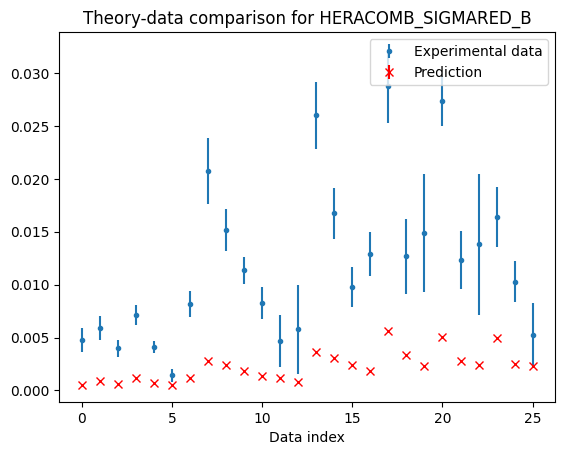

In [4]:
# Let's visualize one of these datasets

def theory_data_comparison(dsname, pdf):
    """Compare the predictions of a given pdf with the selected dataset
    
    Note that in this example we are using the custom layers that we have created as if they were
    numpy operations, without creating a model out of them!
    """
    # The data is in the `.npz` format which can be loaded by the numpy "load" function
    data = np.load(data_folder / f"{dsname}.npz")
    x = data.get("xgrid").reshape(1, -1, 1)
    lbasis = data.get("luminosity")
    fktable = data.get("fktable")
    experimental_data = data.get("D")

    # Rotate the PDF (evaluated in the grid in x)
    evolution_pdf = EvolutionRotation()(pdf(x))
    convolution_layer = Convolution(fktable, lbasis)
    
    theory_predictions = convolution_layer(evolution_pdf)
    
    # Approximate experimental errors with the diagonal of the covariance matrix
    errors = np.sqrt(np.diag(data.get("covmat")))
    idata = np.arange(len(experimental_data)) # we don't have information about the kinematic variable
    
    plt.title(f"Theory-data comparison for {dsname}")
        
    plt.errorbar(idata, experimental_data, yerr=errors, fmt=".", label="Experimental data")
    plt.errorbar(idata, theory_predictions, yerr=0.0, fmt="x", color="red", label="Prediction")
    plt.legend()
    plt.xlabel("Data index")
    
    
dsname = available_datasets[3]
theory_data_comparison(dsname, pdf_model)

## Train on one dataset

The training on datasets is a bit more subtle than the simple training with the PDF as the target.

When training against a PDF we had a situation in which every point in the input corresponds to a single point in the output, so the loss function (and the model) is a relatively simple one:

\begin{equation}
    l(x) = y(x) - t(x)
\end{equation}

However, now in order to train against data we need to perform the integral (which we approximate by a convolution). This means that many values of `x` correspond to a single value of the output. And many values of the output are generated by the same input grid.

There are several solutions to this, in our case we are going to modify the input so that it is a (nx, nd) grid, i.e., (number of points in x, number of dimensions) and we will create a custom loss function (which we would need in order to compute the chi2 with the covariance matrix being considered).

This is why we needed the `None` input dimension when we created the PDF! That `None` is a placeholder that will correspond to the number of points in x.

In [5]:
dsname = available_datasets[3]
data = np.load(data_folder / f"{dsname}.npz")
x = data.get("xgrid").reshape(1, -1, 1)  # 1 batch, N datapoints, n dim
lbasis = data.get("luminosity")
fktable = data.get("fktable")
experimental_data = data.get("D")

print(f"Training for {dsname}")

Training for HERACOMB_SIGMARED_B


Training started...


2023-07-21 19:01:44.392535: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


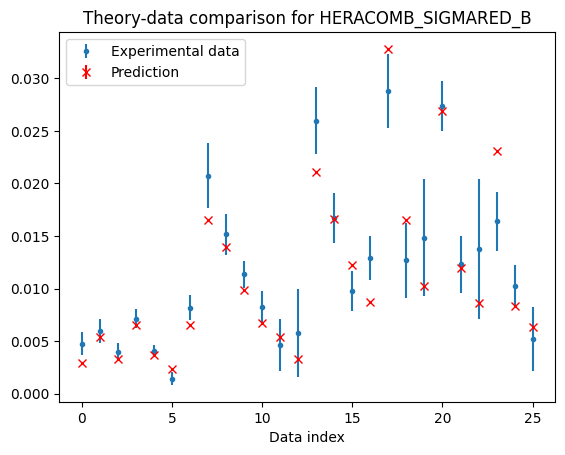

In [6]:
# Let's construct a model
pdf_model = generate_pdf_model()

# Build the necessary layers
evolution_layer = EvolutionRotation()
convolution_layer = Convolution(fktable, lbasis)

# And prepare the observable model
obs_model = keras.models.Sequential([pdf_model, evolution_layer, convolution_layer])


def chi2_simplified(ytrue, ypred):
    """Loss function to pass to the model"""
    return tf.reduce_sum((ytrue - ypred) ** 2)


# And make into a machine learning model
obs_model.compile(keras.optimizers.Nadam(), loss=chi2_simplified)
print("Training started...")
history = obs_model.fit(x, experimental_data.reshape(1, -1), epochs=1000, verbose=0)
theory_data_comparison(dsname, pdf_model)

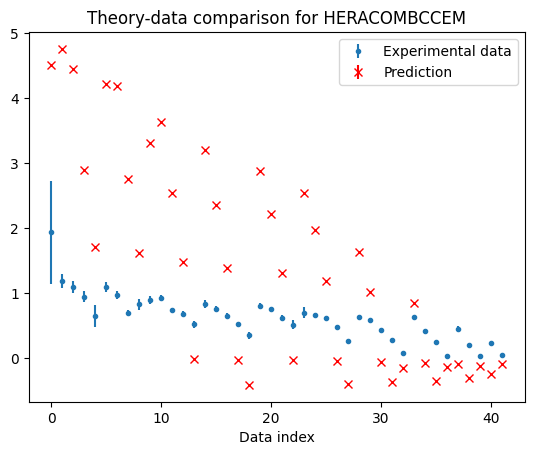

In [7]:
theory_data_comparison(available_datasets[1], pdf_model)

## Train on multiple datasets


For that we are going to generate several separated observable models that all use the same `pdf_model`.
At the end we will concatenate all such models. At the end we will compare with the same data for HERACOMB_SIGMARED_B.

Note that the input grid in x is always the same. This allow us to greatly simplify the model. In general they can be different and this could be treated from the point of view of your model (where each observable will take a different input) or by a preprocessing of the data (adding extra 0s if necessary).

Training started...


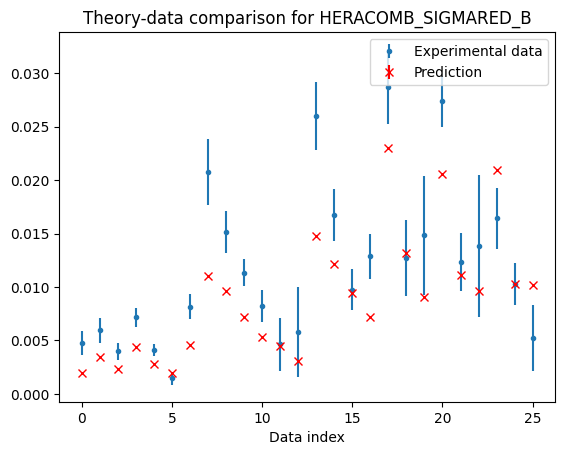

In [8]:
# Let us now train with all the datasets that we have

pdf_model = generate_pdf_model()
evolution_layer = EvolutionRotation()

output_data = []
observables = []
covmats = []  # Let's save the covmats to use them later!

# Let's recover a reference to the initial layer, the information is always available
# this will allow us to instantiate our observable model with the same input shape
model_input = pdf_model.input

for dsname in available_datasets:
    data = np.load(data_folder / f"{dsname}.npz")
    x = data.get("xgrid").reshape(1, -1, 1)
    lbasis = data.get("luminosity")
    fktable = data.get("fktable")
    covmat = data.get("covmat")
    experimental_data = data.get("D").reshape(1, -1)

    convolution = Convolution(fktable, lbasis)

    obs = keras.models.Sequential([pdf_model, evolution_layer, convolution])

    observables.append(obs(model_input))
    covmats.append(covmat)
    output_data.append(experimental_data)

# Create the concatenation of all observables
final_layer = keras.layers.Concatenate()(observables)
final_model = keras.models.Model(model_input, final_layer)

# Concatenate input and output
output = np.concatenate(output_data, axis=-1)

# And make into a machine learning model
final_model.compile(keras.optimizers.Nadam(), loss=chi2_simplified)
print("Training started...")
epochs = 500
history = final_model.fit(x, output, epochs=epochs, verbose=0)
theory_data_comparison(dsname, pdf_model)

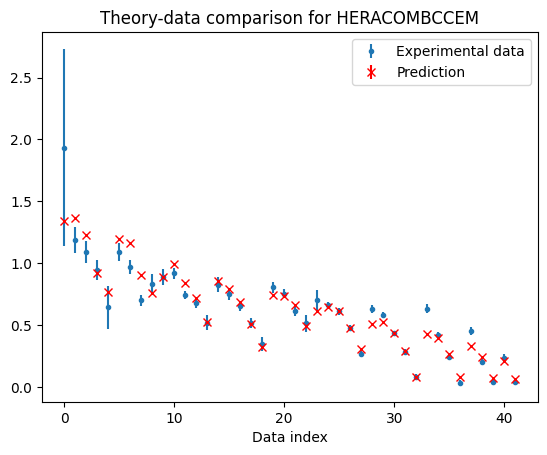

In [9]:
theory_data_comparison(available_datasets[1], pdf_model)

## Including experimental errors

Let us summarize what we have done up to now: we have create one single PDF model which takes as input a single grid in x and produces a pdf values for this grid in x. Then the results of this PDF are rotated into the evolution basis and convoluted with an interpolation table to produce a physical observable.

Note that while all our models utilize the same convolution and rotation, this is not a requirement. Indeed, we could in the same fit include FKTables for DIS and hadronic observables, include extra contribution or physical constraints.

For the output of the model, we have considered that all datapoints are created equal and have concatenated the outputs and compared against a concatenation of the experimental results. This is, as well, not a requirement.
In the next exercise we are going to skip the concatenation step to create a model that has several outputs (one per dataset) which are then tested against as many loss functions.

In [10]:
class Chi2:
    def __init__(self, covmat):
        self._invcovmat = tf.constant(np.linalg.inv(covmat), dtype=tf.float32)
        
    def __call__(self, ytrue, ypred):
        tmp = (ytrue - ypred)
        return tf.einsum("bi,ij,bj->b", tmp, self._invcovmat, tmp)

Training started...


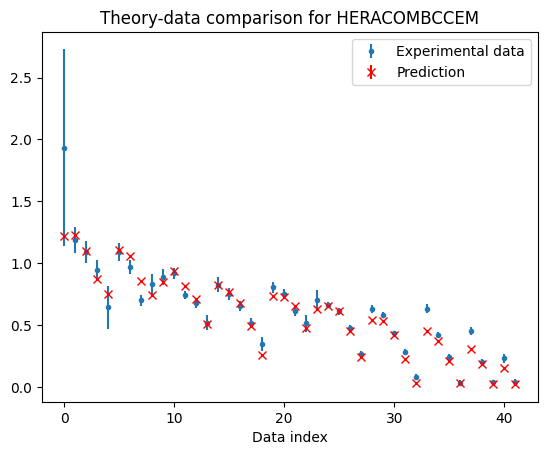

In [11]:
# Remember how before we keep a list with all the observables and covmats?

chi2_list = []
for covmat in covmats:
    chi2_list.append(Chi2(covmat))

# Reset the weights of the pdf model
pdf_model.get_layer("pdf").set_weights(
    keras.models.clone_model(pdf_model.get_layer("pdf")).get_weights()
)

split_model = keras.models.Model(model_input, observables)
split_model.compile(keras.optimizers.Nadam(), loss=chi2_list)
print("Training started...")
history = split_model.fit(x, output_data, epochs=500, verbose=0)
theory_data_comparison(available_datasets[1], pdf_model)

And we could even compute the chi2 now :)

In [12]:
chi2 = split_model.evaluate(x, output_data, verbose=False)
chi2_per_n = np.array(chi2) / np.array([i.shape[-1] for i in output])

for dataset, chi2n in zip(available_datasets, chi2_per_n):
    print(f"For {dataset:20s} we obtain a chi2/n of {chi2n:.2}")

For HERACOMBNCEP920      we obtain a chi2/n of 3.1
For HERACOMBCCEM         we obtain a chi2/n of 2.7
For SLACP                we obtain a chi2/n of 0.19
For HERACOMB_SIGMARED_B  we obtain a chi2/n of 0.092


## Generate data replicas

Finally, we are going to use the Monte Carlo replica method to generate also an error bar for the predictions.

The basis of this method, once we have arrived to this point, is actually quite simple. We are going to generate variations of the output data according to the covariance matrix of each dataset. These variations will be random.

In [13]:
from dataclasses import dataclass

In [14]:
# First let's save all the information that is shared by all the replicas
# (note that the PDF model is not among that!)

from dataclasses import dataclass


@dataclass
class Dataset:
    name: str
    expdata: np.ndarray
    covmat: np.ndarray
    convolution: Convolution
    chi2: Chi2

    @property
    def ndata(self):
        return self.expdata.shape[-1]

    def generate_replica(self):
        r = -0.5 + np.random.rand(self.ndata)
        return self.expdata + np.dot(self.covmat, r).reshape(1, -1)


datasets = []

for dsname in available_datasets:
    data = np.load(data_folder / f"{dsname}.npz")
    x = data.get("xgrid").reshape(1, -1, 1)
    lbasis = data.get("luminosity")
    fktable = data.get("fktable")
    covmat = data.get("covmat")
    edata = data.get("D").reshape(1, -1)

    chi2 = Chi2(covmat)
    cc = Convolution(fktable, lbasis)
    dd = Dataset(dsname, edata, covmat, cc, chi2)

    datasets.append(dd)

In [15]:
# Now train all the replicas

evolution_layer = EvolutionRotation()
nreplicas = 5
epochs_per_replica = 100

pdfs = []

for replica in range(nreplicas):
    pdf_model = generate_pdf_model()
    pdfs.append(pdf_model)
    model_input = pdf_model.input

    exp_data = []
    observables = []
    losses = []
    for ds in datasets:
        obs = keras.models.Sequential([pdf_model, evolution_layer, ds.convolution])
        observables.append(obs(model_input))
        losses.append(ds.chi2)
        exp_data.append(ds.generate_replica())

    split_model = keras.models.Model(model_input, observables)
    split_model.compile(keras.optimizers.Nadam(), loss=losses)
    print(f"Training started for replica {replica}")
    history = split_model.fit(x, exp_data, epochs=epochs_per_replica, verbose=0)
    print(f" done!")

Training started for replica 0
 done!
Training started for replica 1
 done!
Training started for replica 2
 done!
Training started for replica 3
 done!
Training started for replica 4
 done!


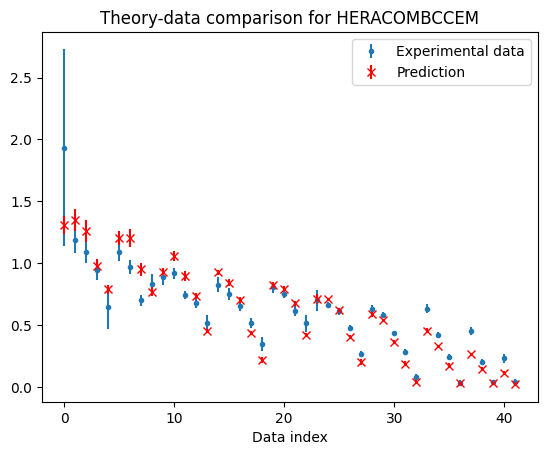

In [16]:
def theory_data_comparison_replicas(dsname, pdf_replicas):
    """Like `theory_data_comparison` but for a list of PDF replicas"""
    # The data is in the `.npz` format which can be loaded by the numpy "load" function
    data = np.load(data_folder / f"{dsname}.npz")
    x = data.get("xgrid").reshape(1, -1, 1)
    lbasis = data.get("luminosity")
    fktable = data.get("fktable")
    experimental_data = data.get("D")

    results = []
    # Rotate the PDF (evaluated in the grid in x)
    for pdf in pdf_replicas:
        evolution_pdf = EvolutionRotation()(pdf(x))
        convolution_layer = Convolution(fktable, lbasis)
        theory_predictions = convolution_layer(evolution_pdf)
        results.append(theory_predictions)

    results = np.array(results)

    central_value = np.average(results, axis=0)
    std = np.std(results, axis=0)

    # Approximate experimental errors with the diagonal of the covariance matrix
    errors = np.sqrt(np.diag(data.get("covmat")))
    idata = np.arange(
        len(experimental_data)
    )  # we don't have information about the kinematic variable

    plt.title(f"Theory-data comparison for {dsname}")

    plt.errorbar(idata, experimental_data, yerr=errors, fmt=".", label="Experimental data")
    plt.errorbar(idata, central_value, yerr=std, fmt="x", color="red", label="Prediction")
    plt.legend()
    plt.xlabel("Data index")


theory_data_comparison_replicas(available_datasets[1], pdfs)